In [1]:
using LinearAlgebra
using SparseArrays

using Plots
using LaTeXStrings

using gmsh
using Gridap
using GridapGmsh

In [2]:
xmin = 0;
xmax = 1;

a = 0.35; b = 0.45;
c = 0.55; d = 0.65;

lc1 = 1e-2;
lc2 = 1e-3;

# Generate Mesh

In [22]:
gmsh.finalize()

In [27]:
gmsh.initialize()

# Nodes
gmsh.model.geo.addPoint(xmin, 0, 0, lc1, 1)
gmsh.model.geo.addPoint(a, 0, 0, lc2, 2)
gmsh.model.geo.addPoint(b, 0, 0, lc2, 3)
gmsh.model.geo.addPoint(c, 0, 0, lc2, 4)
gmsh.model.geo.addPoint(d, 0, 0, lc2, 5)
gmsh.model.geo.addPoint(xmax, 0, 0, lc1, 6)

# Elements
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 5, 4)
gmsh.model.geo.addLine(5, 6, 5)

# Physical properties
gmsh.model.addPhysicalGroup(1, [1, 3, 5], 1)
gmsh.model.addPhysicalGroup(1, [2, 4], 2)

gmsh.model.addPhysicalGroup(0, [1,6], 1)
gmsh.model.setPhysicalName(0, 1, "D") # Dirichlet boundary condition

# 
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(1)

gmsh.write("ms_planar.msh")

# Retrieve nodes from gmsh
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
xnode = node_coord[1:3:end];
p = sortperm(xnode);
x = xnode[p];
nids = node_ids[p];

gmsh.fltk.run()

gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.0378981s, CPU 0.046875s)
Info    : 481 nodes 486 elements
Info    : Writing 'ms_planar.msh'...
Info    : Done writing 'ms_planar.msh'
-------------------------------------------------------
Version       : 4.9.4
License       : GNU General Public License
Build OS      : Windows64-sdk
Build date    : 20220203
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen NoSocklenT ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangl

# FEM

In [34]:
function get_idx(node_id, nids)
    return findall(x -> x == node_id, nids)[1];
end

function bnd_dirichlet(idx, a, A, f)
    A[idx,:]   = zeros(length(f));
    A[idx,idx] = 1;
    f[idx] = a;
    
    return A, f;
end

bnd_dirichlet (generic function with 1 method)

In [35]:
#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
points = collect( [x[i], x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1] for i in 1:length(x)-1); 

#..Set the source function 
J = 1e6;
fsource(x) = J * (x > a) * (x < b) - J * (x > c) * (x < d); 

mu0 = 4e-7 * pi;
mu_r = 1000;
mu(x) = mu0 + (mu_r - 1) * mu0 * (x > b) * (x < c);
cfun(x) = 1 / mu(x);

#..Initialize global matrix and right-hand side value 
A = zeros(length(x), length(x)); 
f = zeros(length(x)); 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:length(edges) 
    xl, xr = points[i,:][1]
    floc = (xr-xl) / 2 * [fsource(xl); fsource(xr)];
    Aloc = (cfun(xr)+cfun(xl)) / (2*(xr-xl)) * [1 -1; -1 1]; 

    f[edges[i]] += floc;
    A[edges[i], edges[i]] += Aloc;
end

#..handle the boundary conditions in the matrix and right-hand side vector 
A, f = bnd_dirichlet(get_idx(1, nids), 0, A, f);    # Boundary at x = 0
A, f = bnd_dirichlet(get_idx(6, nids), 0, A, f);    # Boundary at x = 1

#..solve the linear system
u  = A \ f;

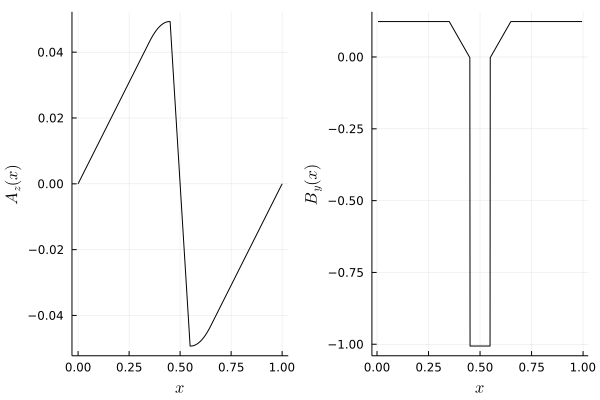

In [7]:
# Post-processing
xmid = diff(x) / 2 + x[1:end-1];
ux = diff(u) ./ diff(x);

# Plot
p1 = plot(x, u, xlabel = L"x", ylabel = L"A_z(x)", color = :black, lw = 1, legend = false);
p2 = plot(xmid, ux, xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, legend = false);

plot(p1, p2)

# Verification with Gridap

In [29]:
# Use GridapGmsh to load the geometry
model = GmshDiscreteModel("ms_planar.msh");

# Create a reference finite element space to use for the construction of test space V0
#  The FE space is Lagrangian and of order 1
order = 1
reffe = ReferenceFE(lagrangian, Float64, order);
# The test space is created from the reference FE with
#  conformity = H1: shape functions are continuous
#  D1 and D2 being the boundary points with Dirichlet condition applied
V0 = TestFESpace(model, reffe; conformity = :H1, dirichlet_tags = ["D"]);

Ug = TrialFESpace(V0, [0]);

degree = 2 * order;
Ω = Triangulation(model);
dΩ = Measure(Ω, degree);

# Source function and variable diffusion coefficient
J = 1e6;
fsource(x) = J * (x[1] > a) * (x[1] < b) - J * (x[1] > c) * (x[1] < d); 

mu0 = 4e-7 * pi;
mu_r = 1000;
mu(x) = mu0 + (mu_r - 1) * mu0 * (x > b) * (x < c);
cfun(x) = 1 / mu(x[1]);

# Construct weak form
lhs(u,v) = ∫( cfun * ∇(v) ⋅ ∇(u) )dΩ;
rhs(v)   = ∫( v * fsource  )dΩ;

# Construct FE operator
op = AffineFEOperator(lhs, rhs, Ug, V0);

ls = LUSolver()
solver = LinearFESolver(ls)

uh = solve(solver, op);

Info    : Reading 'ms_planar.msh'...
Info    : 11 entities
Info    : 481 nodes
Info    : 482 elements
Info    : Done reading 'ms_planar.msh'


In [36]:
# Load mesh nodes and evaluate solution
coord = model.grid.node_coordinates;
xg = [coord[i][1] for i in 1:length(coord)]
ug = uh(coord);

# Sort nodes and solution in increasing order of x for plotting
p = sortperm(xg);
xg = xg[p];
ug = ug[p];

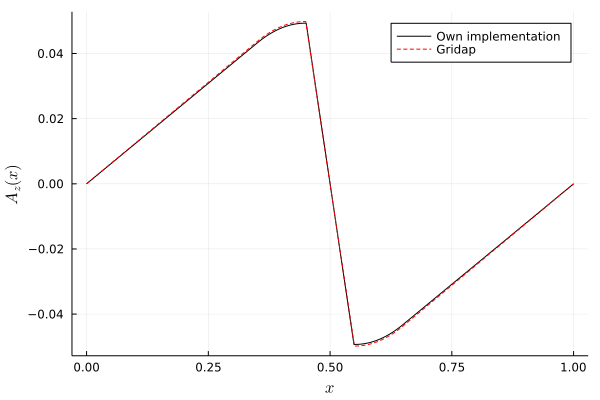

In [44]:
# Post-processing
xgmid = diff(xg) / 2 + xg[1:end-1];
ugx = diff(ug) ./ diff(xg);

# Plot
plot(x, u, xlabel = L"x", ylabel = L"A_z(x)", color = :black, lw = 1, label = "Own implementation");
plot!(xg, ug, style = :dash, color = :red, lw = 1, label = "Gridap")

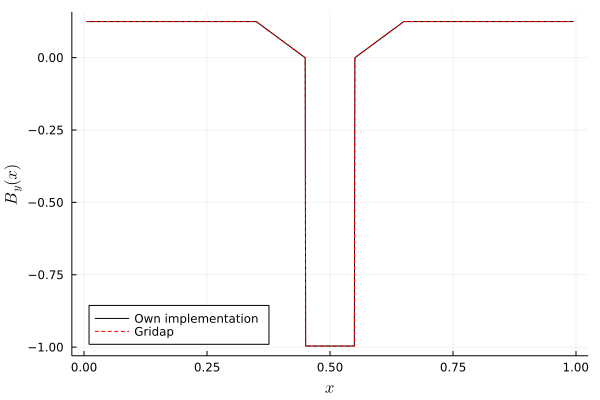

In [48]:
plot(xmid, ux, xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, label = "Own implementation", legend = :bottomleft);
plot!(xgmid, ugx, style = :dash, color = :red, lw = 1, label = "Gridap")